# Hoax Detection Using LSTM

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Reading data

In [2]:
df = pd.read_csv('dataset berita hoax indonesia/600 news with valid hoax label.csv', error_bad_lines=False, encoding='ANSI', delimiter=';')

In [3]:
df.head()

,berita,tagging
0,"Jakarta, Di jejaring sosial, banyak beredar in...",Valid
1,Isu bahwa ikan lele mengandung sel kanker di j...,Valid
2,Bagi penikmat kuliner dengan bahan dasar ikan ...,Valid
3,Ikan lele merupakan salah satu makanan favorit...,Valid
4,Ikan lele merupakan bahan makanan yang cukup p...,Valid


C:\Users\Fazil Tirtana\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of real and fake news')

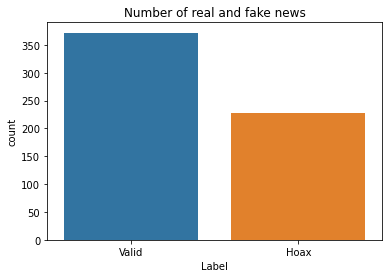

In [4]:
sns.countplot(df.tagging)
plt.xlabel('Label')
plt.title('Number of real and fake news')

# Text Preprocessing
##### this includes:
- convert all text to lower case
- replace REPLACE_BY_SPACE_RE symbols by space in text
- remove symbols that are in BAD_SYMBOLS_RE from text
- remove stop words and removing digits in text

In [5]:
from nltk.corpus import stopwords
import regex as re


df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('indonesian'))

def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

df['berita'] = df['berita'].apply(clean_text)
df['berita'] = df['berita'].str.replace('\d+', '')

In [6]:
df['berita']

0      jakarta jejaring sosial beredar informasi meny...
1      isu ikan lele mengandung sel kanker jejaring s...
2      penikmat kuliner bahan dasar ikan lele berita ...
3      ikan lele salah makanan favorit indonesia harg...
4      ikan lele bahan makanan populer indonesia ters...
                             ...                        
595    kabar beredar seputar rencana kenaikan gaji pr...
596    kabar beredar seputar rencana kenaikan gaji pr...
597    akhirakhir beredar pemberitaan kenaikan gaji p...
598    rancangan peraturan pemerintah rpp gaji tunjan...
599    kabar beredar seputar rencana kenaikan gaji pr...
Name: berita, Length: 600, dtype: object

# Data processing
- Tokenize the data and convert the text to sequences.
- Add padding to ensure that all the sequences have the same shape.

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

MAX_NB_WORDS = 1000
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM = 100

Tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
Tokenizer.fit_on_texts(df['berita'].values)
word_index = Tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 12015 unique tokens.


In [8]:
X = Tokenizer.texts_to_sequences(df['berita'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (600, 150)


In [9]:
Y = df['tagging']
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (600, 1)


# Split into training and test data.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(540, 150) (540, 1)
(60, 150) (60, 1)


# LSTM model

In [12]:
from keras.layers import LSTM,Dense,Dropout,Input,Embedding,Activation
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras.backend

In [13]:
keras.backend.clear_session()

inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
layer = Embedding(MAX_NB_WORDS,50,input_length=MAX_SEQUENCE_LENGTH)(inputs)
layer = LSTM(64)(layer)
layer = Dense(256,name='FC1')(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(1,name='out_layer')(layer)
layer = Activation('sigmoid')(layer)
model = Model(inputs=inputs,outputs=layer)
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

epochs = 200
batch_size = 128

history = model.fit(X_train,Y_train,batch_size=batch_size,epochs=epochs,validation_split=0.2,callbacks=EarlyStopping(monitor='val_loss', patience=5, verbose=1))

Epoch 1/200
4/4 [==============================] - 3s 470ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6740 - val_accuracy: 0.5926
Epoch 2/200
4/4 [==============================] - 0s 87ms/step - loss: 0.6563 - accuracy: 0.6266 - val_loss: 0.6621 - val_accuracy: 0.5926
Epoch 3/200
4/4 [==============================] - 0s 90ms/step - loss: 0.6312 - accuracy: 0.6147 - val_loss: 0.6412 - val_accuracy: 0.6111
Epoch 4/200
4/4 [==============================] - 0s 87ms/step - loss: 0.5396 - accuracy: 0.6967 - val_loss: 0.6077 - val_accuracy: 0.6296
Epoch 5/200
4/4 [==============================] - 0s 82ms/step - loss: 0.5319 - accuracy: 0.8180 - val_loss: 0.5905 - val_accuracy: 0.6204
Epoch 6/200
4/4 [==============================] - 0s 81ms/step - loss: 0.4626 - accuracy: 0.8751 - val_loss: 0.5746 - val_accuracy: 0.6481
Epoch 7/200
4/4 [==============================] - 0s 82ms/step - loss: 0.3772 - accuracy: 0.8625 - val_loss: 0.5746 - val_accuracy: 0.6667
Epoch 8/200
4/4 [==

# Model Evaluation

In [14]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2/2 [==============================] - 0s 12ms/step - loss: 0.3886 - accuracy: 0.8500
Test set
  Loss: 0.389
  Accuracy: 0.850


# Visual

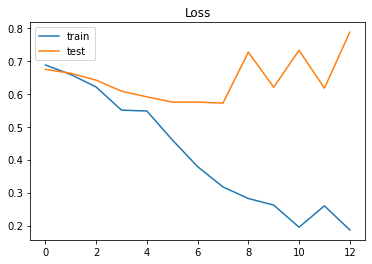

In [15]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

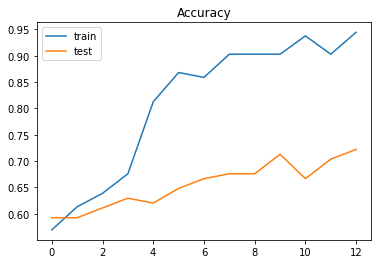

In [16]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# Test with new/custom input

In [17]:
new_input = ['Pasien COVID-19 tanpa gejala dalam penelitian ini dibagi menjadi dua kelompok. Pertama, kelompok pra-gejala atau orang yang menyebarkan virus sebelum menunjukkan gejala. Kedua, kelompok orang yang mungkin tidak pernah mengembangkan gejala apa pun, tetapi tetap menularkan virus.Studi ini pun menunjukkan bahwa kedua kelompok tersebut tampaknya memainkan peran penting dalam penyebaran virus Corona. Sekitar 35 persen penularan virus berasal dari kelompok pasien pra-gejala. Sementara 24 persen berasal dari mereka yang tidak pernah mengalami gejala.Oleh karena itu, para peneliti pun mencatat sebaiknya tes COVID-19 dilakukan secara lebih luas, terutama kepada orang-orang yang berisiko lebih tinggi menularkan virus Corona pada orang lain.Studi ini juga mempertegas betapa pentingnya mematuhi protokol kesehatan, seperti menggunakan masker, menjaga jarak, dan rutin mencuci tangan untuk meminimalisir penularan virus Corona.']

new_input[0] = clean_text(new_input[0])
new_input[0] = new_input[0].replace('\d+', '')

A = Tokenizer.texts_to_sequences(new_input)
A = pad_sequences(A, maxlen=MAX_SEQUENCE_LENGTH)

pred = model.predict(A)
labels = ['Hoax', 'Valid']

if(pred>0.5):
    print(pred, labels[1])
else:
    print(pred, labels[0])

[[0.9953377]] Valid


# Save model

In [18]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [19]:
from keras.models import model_from_json

In [20]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [21]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 90.33%
